<a href="https://colab.research.google.com/github/gamesMum/Leukemia-Diagnostics/blob/master/Leukemia_Diagnosis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leukemia Diagnostic Model

**Classification of Acute Leukemia using Pretrained Deep Convolutional Neural Networks**
Based on the implementation in the paper:

[**Human-level recognition of blast cells in acute myeloid
leukemia with convolutional neural networks**](https://www.biorxiv.org/content/10.1101/564039v1.full.pdf)

 **The Dataset used in this implementation:**


- AML dataset
-The number of classes are 10:
Abbreviations of morphological classes used in folder structure and annotation file
BAS Basophil
EBO Erythroblast (and Monoblast)
EOS Eosinophil
KSC Smudge cell
LYT Lymphocyte (typical and atypical)
MON Monocyte
MYO Myeloblast (Metamyelocyte and Myelocyte)
NGB Neutrophil (band)
NGS Neutrophil (segmented)
PMO Promyelocyte (bilobled and not)

UNC Image that could not be assigned a class during re-annotation
nan no re-annotation

- link to the dataset https://www.kaggle.com/lsaa2014/single-cell-morphological-dataset-of-leukocytes


# **Materials and Methods**

Please read the paper for more and detailed information.

- peripheral blood smears were selected from 100 patients diagnosed with different subtypes
of AML at the Laboratory of Leukemia Diagnostics at Munich University Hospital between 2014 and 2017, and smears from 100 patients found to exhibit no morphological
features of hematological malignancies in the same time frame.

- The resulting digitised data consisted of multiresolution pyramidal images of a size of approximately 1 GB per scanned area of interest.
A trained examiner experienced in routine cytomorphological diagnostics at Munich University Hospital differentiated physiological and pathological leukocyte types contained
in the microscopic scans into the classification scheme (see fig 2B),
which is derived from standard morphological categories and was refined to take into account subcategories relevant for the morphological classification of AML, such as bilobed Promyelocytes, which are typical of the FAB subtype M3v.
-  Annotation was carried out on a
single-cell basis, and approximately 100 cells were differentiated in each smear
- Subimage patches of size 400 x 400 pixels (corresponding to approximately 29µm x 29µm)
around the annotated cells were extracted without further cropping or filtering, including
background components such as erythrocytes, platelets or cell fragments.
- When examining the screened blood smears, the cytologist followed the routine clinical procedure.
Overall, 18,365 single-cell images were annotated and cut out of the scan regions.

- Annotations of single-cell images provide the ground truth for training and evaluation
of our network.

- Morphological classes containing fewer than 10 images were merged with
neighbouring classes of the taxonomy.

- A subset of 1,905 single-cell images from all morphological categories were presented to a second, independent examiner, and annotated
for a second time in order to estimate inter-rater variability

**For Implementation:**
-	The network was adopted  to input image dimensions of 400 x 400 x 3
-	No further cropping or ﬁltering.
-	Retained the cardinality hyper-parameter at C = 32.
-	The ﬁnal dense layer adapted to our 10-category classiﬁcation scheme.
-	Annotations of single-cell images provide the ground truth for training and evaluation of the network
-	There are 10 classes for training and evaluation.
-	For our image classiﬁcation task, we used a Alexnet
-	The network was trained for at least 20 epochs, which took a computing time of approximately 4 days on a Nvidia GeForce GTX TITAN X GPU.
-	The test group contains 20%, and the validation group 20% of the images
-	Random rotational transformations of 0−359 degrees, as well as random horizontal and vertical ﬂips to the single-cell images in the dataset.
-	In the end the data set was augmented in such a way that each class contained approximately 10,000 images for training. (This is from the origional paper that had 15 classes, but this number increased in this implementation since some of the classes were combined)
- You'll see that we implemented a technique to choose and cycle between different learning rate values. This implementation is based on the paper by Leslie Smith here: https://arxiv.org/abs/1506.01186 and with the help of this great article by Thomas Dehaene
https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee. More details found as you go along








In [0]:
#inporting the necessary libraries
import numpy as np
import torch
from torch import nn
from torchvision import transforms, datasets, models
import math
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision as tv

In [0]:
#check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("CUDA is available. Training on GPU!")
else:
    print("CUDA is not available. Training on CPU.")

CUDA is available. Training on GPU!


In [0]:
#time to prepare the data

batch_size = 32
test_size = 0.20
valid_size = 0.20

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


#define the transforms
train_transform  = transforms.Compose([
                                        transforms.Resize((400,400)),
                                        transforms.RandomRotation(359),
                                        transforms.RandomHorizontalFlip(0.2),
                                        transforms.RandomVerticalFlip(0.2),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std)])



train_data = datasets.ImageFolder("/kaggle/input/single-cell-morphological-dataset-of-leukocytes/blood_smear_images_for_aml_diagnosis_MOD/AML-Cytomorphology_LMU_MOD",
                                  transform = train_transform)

#obtain training indicies that will be used as testing and validation

num_train = len(train_data)
indicies = list(range(num_train))
np.random.shuffle(indicies)
test_split = int(np.floor(test_size * num_train))
valid_split = int(np.floor(valid_size * num_train))

train_idx, valid_idx, test_idx = indicies[test_split+valid_split:], indicies[:valid_split], indicies[valid_split:test_split+valid_split]

#define samplers for obtainig the trainig, testing and validation set
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = test_sampler)

valid_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size,
                                          sampler = valid_sampler)


#  PROMYELOCYTE (PMB Promyelocyte (bilobled))
# PMO Promyelocyte), MYELOCYTE (MYB Myelocyte, MYO Myeloblast)ARE FOUND ON LEUKEMIA PATIENTS 
classes = ['BAS', 'EBO', 'EOS', 'KSC','LYT','MON', 'MYO', 'NGB', 'NGS', 'PMO']



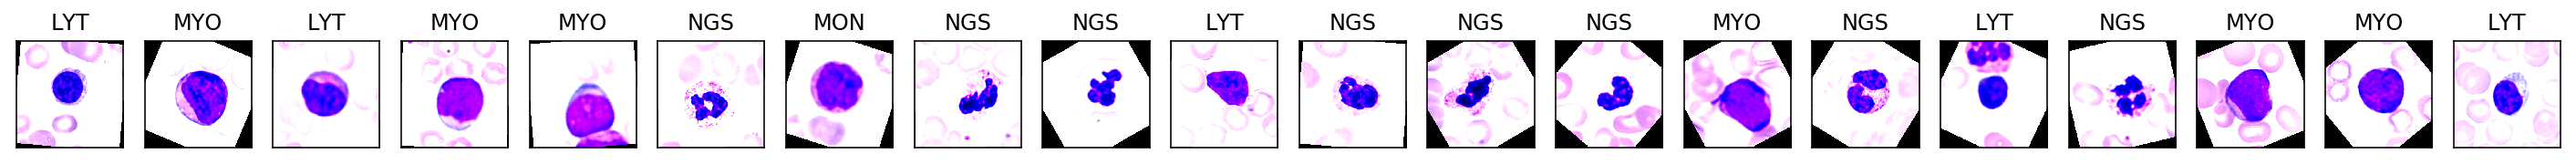

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def imshow(img):
  img = img /2+0.5 #unormalize the images
  plt.imshow(np.transpose(img, (1, 2, 0))) #convert it back from tensor to image

#get one batch of training images
dataiter = iter(train_loader) #now contains the first batch
images, labels = dataiter.next() #images=the first batch of images, labels= the first batch of labels
images = images.numpy() #convert the images to display them

#plot the imahes in the batch along with the corresponding labels
fig = plt.figure(figsize=(25,6))

for idx in np.arange(20):
  ax = fig.add_subplot(1, 20, idx+1, xticks=[], yticks=[]) #(rows, cols, index, .., ..)
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [0]:
#Load AlexNet pretrained model
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
#freeze the model calssifier
for param in model.features.parameters():
  param.requires_grad = False

from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
                            
                          ('fc1', nn.Linear(4096, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 10))]))
#('output', nn.LogSoftmax(dim=1)

model.classifier[6] = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<h2>Choose how to train</h2>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li>
            <a href="#normal">Normal Training</a>
        </li>
        <li>
            <a href="#cyclical">With Cyclical Learning Rate</a>
        </li>
        <li>
            <a href="#inference">Test our model</a>
        </li>
    </ul>
</div>

<hr>

<a id="normal"></a>
## Normal Training

In [0]:
import torch.optim as optim
#Loss function and optmixation function
criterion = nn.CrossEntropyLoss()
# the optimizer accepts only the trainable parameters
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

if train_on_gpu:
    model.cuda()

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss (comapre the values of the output model to the actual labels)
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for images, labels in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        valid_loss_min = valid_loss
        # print the decremnet in the validation
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min, 
        valid_loss))
        torch.save(model.state_dict(), 'model_AML_classifier.pt')
        
    if epoch % 10 == 0:    
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.937266 	Validation Loss: 0.585251
Validation loss decreased (0.585251 --> 0.585251).  Saving model ...
Epoch: 2 	Training Loss: 0.521484 	Validation Loss: 0.459086
Validation loss decreased (0.459086 --> 0.459086).  Saving model ...
Epoch: 3 	Training Loss: 0.448800 	Validation Loss: 0.418038
Validation loss decreased (0.418038 --> 0.418038).  Saving model ...
Epoch: 5 	Training Loss: 0.394268 	Validation Loss: 0.377095
Validation loss decreased (0.377095 --> 0.377095).  Saving model ...
Epoch: 7 	Training Loss: 0.367631 	Validation Loss: 0.366006
Validation loss decreased (0.366006 --> 0.366006).  Saving model ...
Epoch: 8 	Training Loss: 0.354752 	Validation Loss: 0.350403
Validation loss decreased (0.350403 --> 0.350403).  Saving model ...
Epoch: 10 	Training Loss: 0.344237 	Validation Loss: 0.334740
Validation loss decreased (0.334740 --> 0.334740).  Saving model ...
Epoch: 10 	Training Loss: 0.344237 	Validation Loss: 0.334740
Epoch: 12 	Training Loss: 0

In [0]:
model.load_state_dict(torch.load('model_AML_classifier.pt'))

<All keys matched successfully>

In [0]:
#initialize the test loss
test_loss = 0.0

class_correct = list(0. for i in range(10))
class_total = list (0. for i in range(10))

#set the model to test and validation mode (no gradient descent needed)
model.eval()

for data, target in test_loader:
  #move the tensor to GPU ig available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  #forward pass: compute prediction output by passing the first batch of test data
  output = model(data)
  #calculate the batch size
  loss = criterion(output, target)
  #update the test loss
  test_loss += loss.item()*data.size(0)
  #convert output probabilities to output class
  _, pred = torch.max(output, 1)
  #compare the prediction to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  #conveert to numpy array and remove the extra dimention and get only the result
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  #calculate test accuracy for each object class
  for i in range(batch_size):
    try:
      label = target.data[i] #get the corresponding label from the object
      class_correct[label] += correct[i].item()
      class_total[label] += 1
    except IndexError:
      break
  
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
     print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
       print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
   



Test Loss: 0.064096

Test Accuracy of   BAS:  0% ( 0/19)
Test Accuracy of   EBO: 28% ( 6/21)
Test Accuracy of   EOS: 56% (53/94)
Test Accuracy of   KSC:  0% ( 0/ 6)
Test Accuracy of   LYT: 93% (769/822)
Test Accuracy of   MON: 81% (300/366)
Test Accuracy of   MYO: 92% (589/636)
Test Accuracy of   NGB:  0% ( 0/27)
Test Accuracy of   NGS: 97% (1624/1660)
Test Accuracy of   PMO:  4% ( 1/22)

Test Accuracy (Overall): 90% (3342/3673)


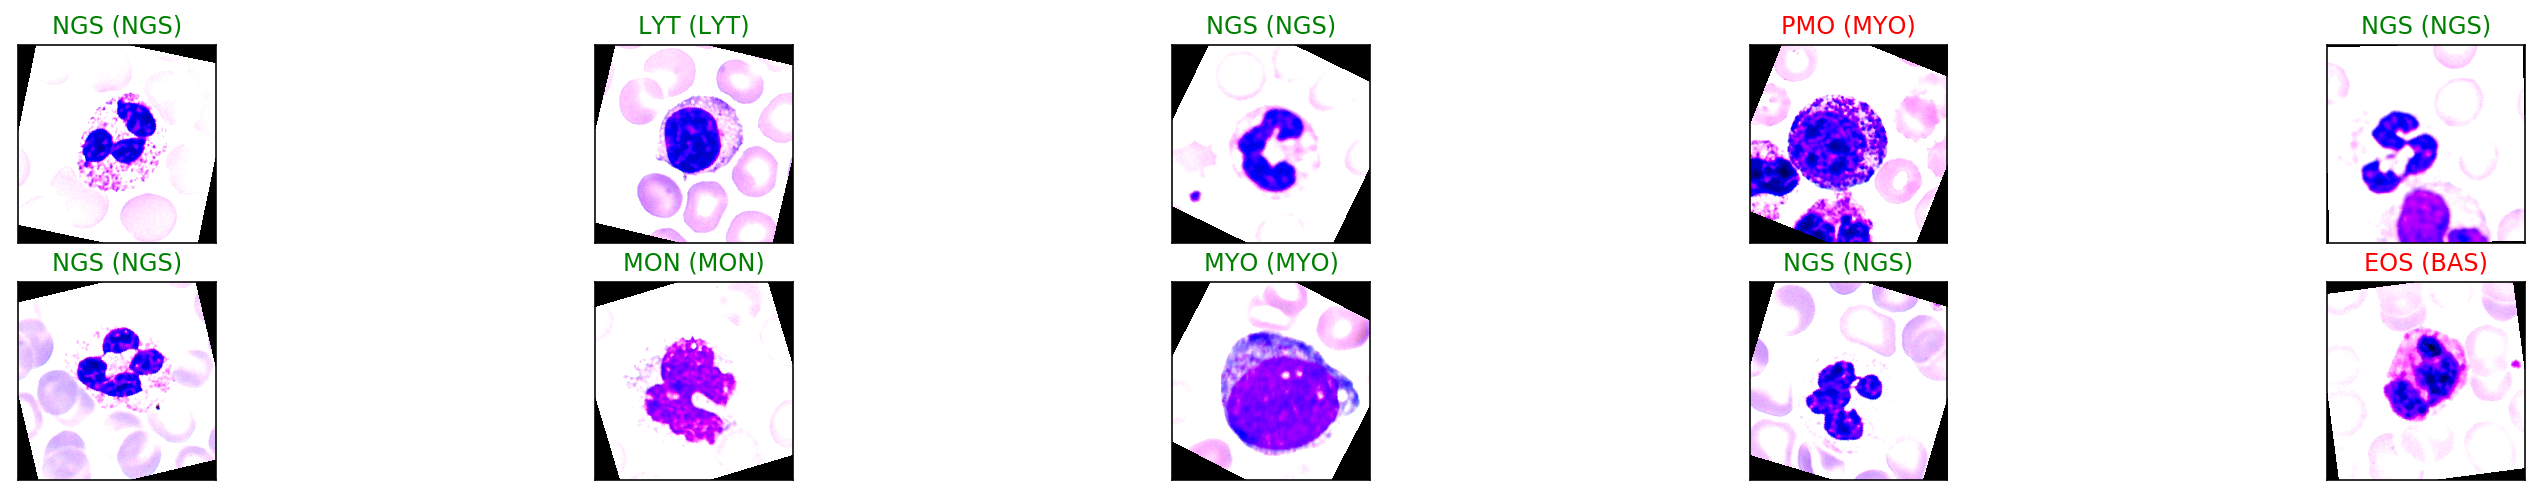

In [0]:

#Move model inputs to cuda
if train_on_gpu:
    images = images.cuda()

#get sample outputs
output = model(images)
#convert probabilties to prediction class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

<a id="cyclical"></a>
## Implementing cyclical learning rate techneque:

- First we need to find the max_lr and the base_lr.
- implement the following experience to do so
Refernce:
- https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee
- https://arxiv.org/pdf/1506.01186.pdf


In [0]:
# Experiment parameters
lr_find_epochs = 2
start_lr = 1e-7
end_lr = 0.1

In [0]:
# Set up the model, optimizer and loss function for the experiment

optimizer = torch.optim.SGD(model.classifier.parameters(), lr=start_lr)
criterion = nn.CrossEntropyLoss()

# y = a.e(-bt) 
# end_lr = start_lr . e(b.t)
# (end_lr - start_lr) = e(b.t)
# ln(end_lr - start_lr) = b.t
# b = ln(end_lr - start_lr) / t

In [0]:
# LR function lambda
from torch.optim.lr_scheduler import LambdaLR
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len( train_loader)))
scheduler = LambdaLR(optimizer, lr_lambda)


In [0]:
# move model to GPU
if train_on_gpu:
    model.cuda()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

- In the following we run two epochs through the network. At each step we are capturing the LR and optimizing the gradient.

In [0]:
# Run the experiment
lr_find_loss = []
lr_find_lr = []

iter = 0

smoothing = 0.05
for i in range(lr_find_epochs):
  print("epoch {}".format(i))
  model.train()
  for inputs, labels in train_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      inputs, labels = inputs.cuda(), labels.cuda()

    optimizer.zero_grad()
    
    # Get outputs to calc loss
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Update LR
    scheduler.step()
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_find_lr.append(lr_step)

    # smooth the loss
    if iter==0:
      lr_find_loss.append(loss)
    else:
      loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
      lr_find_loss.append(loss)
     
    iter += 1

epoch 0
epoch 1


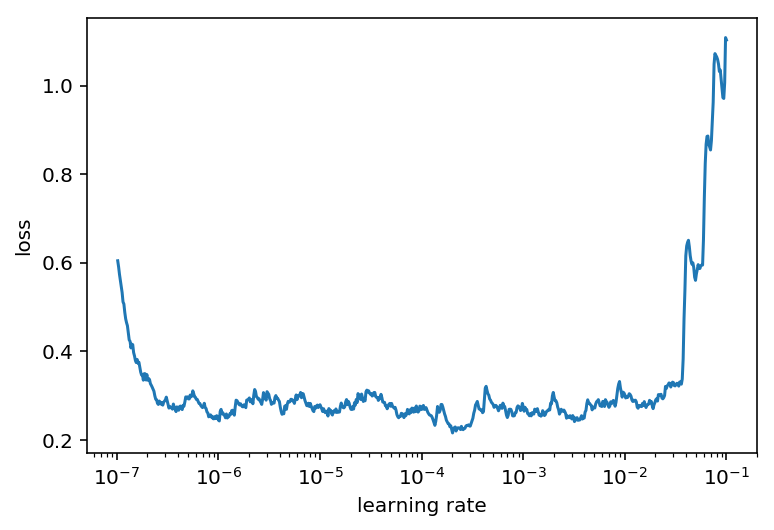

In [0]:
plt.ylabel("loss")
plt.xlabel("learning rate")
plt.xscale("log")
plt.plot(lr_find_lr, lr_find_loss)
plt.show()


- From the figure above, For the upper bound (max). We won't pick the one on lowest point but rather about a factor of ten to the left. 
In this case
the lowest point is about 3e-2 so we'll take 3e-3
- Now for the lowe bound (Min): Acording to the paper and other resouce a good lower bound is the upper divided by 6. So 3e-3/6 = 5e-4

- This approach could also help us find the range of acceptable lr for our model even if we decided to go with a fixed lr. 

In [0]:
# As concluded above
lr_max = 3e-3

### Step 2: The CLR Scheduale
Which varies the learning rate between uper and lower bound.
we are going with triangular CLR schedule.
![triangular schedule](https://drive.google.com/file/d/1K6GraTrK4oV7GOokhFewG-xOmHqKbj75/view?usp=sharing)
- Programatically we just need to create a custom function

In [0]:
def cyclical_lr(stepsize, min_lr=5e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

### Step 3: Wrap it up
- This can be wrapped up inside LamdaLR object in Pytorch

In [0]:


#Parameters
factor = 6
end_lr = lr_max
iter = 0
total_logs = []

#Loss function and optmixation function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=1.)
step_size = 4*len(train_loader)
clr = cyclical_lr(step_size, min_lr=end_lr/factor, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

if train_on_gpu:
    model.cuda()

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Step 4: Time to train our model

In [0]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss (comapre the values of the output model to the actual labels)
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        scheduler.step() # > Where the magic happens
        lr_sched_test = scheduler.get_last_lr()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    
    for images, labels in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        # print the decremnet in the validation
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tLearning rate: {}'.format(
            epoch, train_loss, valid_loss, lr_sched_test))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min, 
        valid_loss))
        torch.save(model.state_dict(), 'model_AML_classifier.pt')
        valid_loss_min = valid_loss
    if epoch % 10 == 0:    
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tLearning rate: {}'.format(
            epoch, train_loss, valid_loss, lr_sched_test))   

Epoch: 1 	Training Loss: 0.951090 	Validation Loss: 0.831305 	Learning rate: [0.0011250000000000001]
Validation loss decreased (inf --> 0.831305).  Saving model ...
Epoch: 2 	Training Loss: 0.706818 	Validation Loss: 0.585452 	Learning rate: [0.00175]
Validation loss decreased (0.831305 --> 0.585452).  Saving model ...
Epoch: 3 	Training Loss: 0.483382 	Validation Loss: 0.413796 	Learning rate: [0.002375]
Validation loss decreased (0.585452 --> 0.413796).  Saving model ...
Epoch: 4 	Training Loss: 0.381860 	Validation Loss: 0.356982 	Learning rate: [0.003]
Validation loss decreased (0.413796 --> 0.356982).  Saving model ...
Epoch: 5 	Training Loss: 0.339888 	Validation Loss: 0.332106 	Learning rate: [0.002375]
Validation loss decreased (0.356982 --> 0.332106).  Saving model ...
Epoch: 6 	Training Loss: 0.318496 	Validation Loss: 0.310922 	Learning rate: [0.00175]
Validation loss decreased (0.332106 --> 0.310922).  Saving model ...
Epoch: 8 	Training Loss: 0.302744 	Validation Loss: 0.3

In [0]:
model.load_state_dict(torch.load('model_AML_classifier.pt'))

<All keys matched successfully>

<a id="inference"></a>
## Test our Model

In [0]:
#initialize the test loss
test_loss = 0.0

class_correct = list(0. for i in range(10))
class_total = list (0. for i in range(10))

#set the model to test and validation mode (no gradient descent needed)
model.eval()

for data, target in test_loader:
  #move the tensor to GPU ig available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  #forward pass: compute prediction output by passing the first batch of test data
  output = model(data)
  #calculate the batch size
  loss = criterion(output, target)
  #update the test loss
  test_loss += loss.item()*data.size(0)
  #convert output probabilities to output class
  _, pred = torch.max(output, 1)
  #compare the prediction to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  #conveert to numpy array and remove the extra dimention and get only the result
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  #calculate test accuracy for each object class
  for i in range(batch_size):
    try:
      label = target.data[i] #get the corresponding label from the object
      class_correct[label] += correct[i].item()
      class_total[label] += 1
    except IndexError:
      break
  
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
     print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
       print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
   

Test Loss: 0.062369

Test Accuracy of   BAS:  0% ( 0/19)
Test Accuracy of   EBO: 23% ( 5/21)
Test Accuracy of   EOS: 63% (60/94)
Test Accuracy of   KSC:  0% ( 0/ 6)
Test Accuracy of   LYT: 92% (758/822)
Test Accuracy of   MON: 83% (304/366)
Test Accuracy of   MYO: 93% (594/636)
Test Accuracy of   NGB:  0% ( 0/27)
Test Accuracy of   NGS: 97% (1625/1660)
Test Accuracy of   PMO:  4% ( 1/22)

Test Accuracy (Overall): 91% (3347/3673)


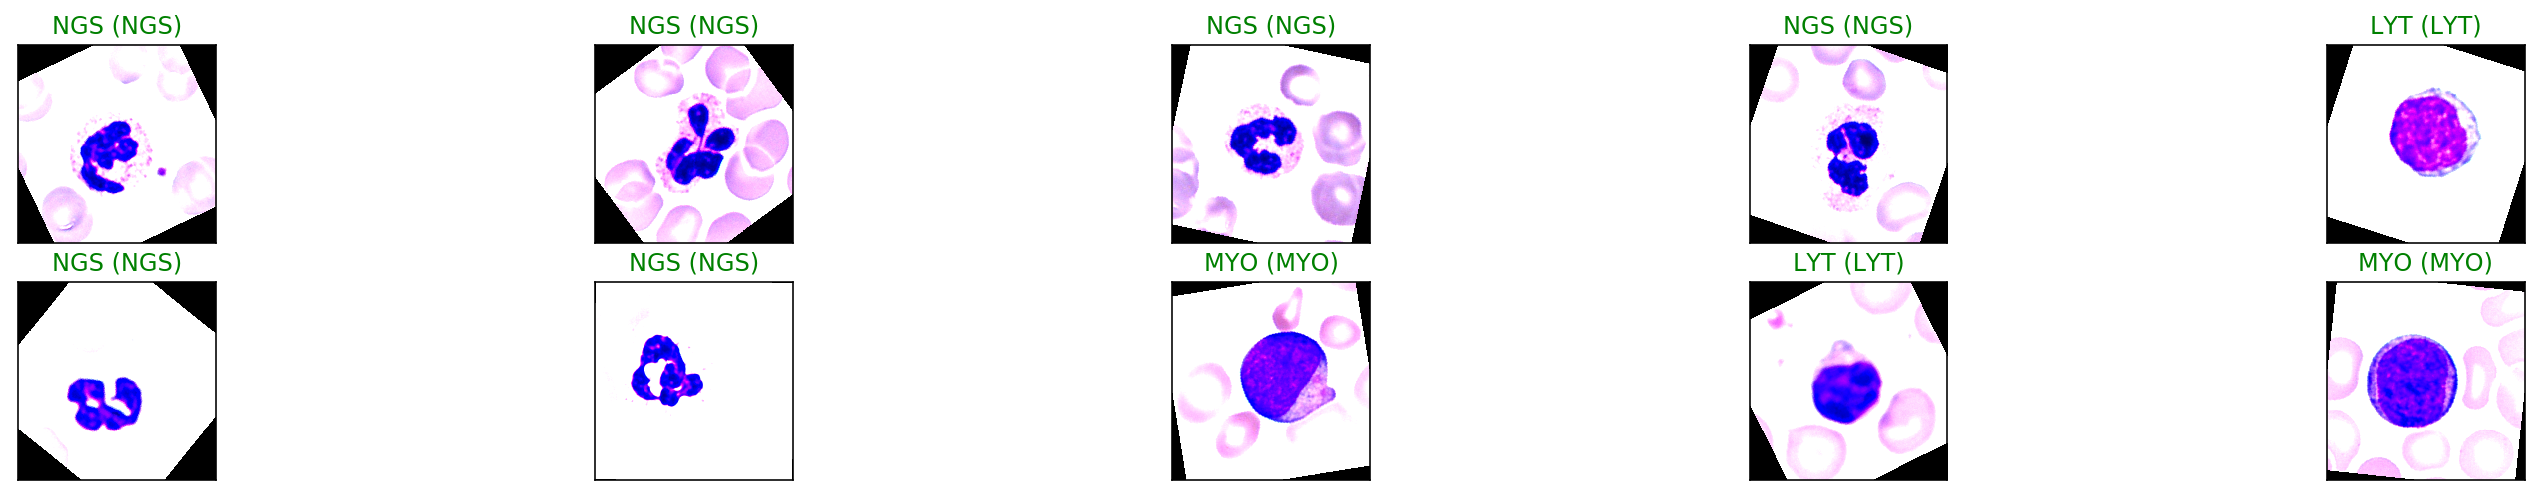

In [0]:

#Move model inputs to cuda
if train_on_gpu:
    images = images.cuda()

#get sample outputs
output = model(images)
#convert probabilties to prediction class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### Notes:

- make sure that the tarin, test, validation sets are randomly picked so they containe images from all calsses.
- less lr better (stable) training
- make sure my data is well distrbuted (more images most be obtaine)
- The deeper the CNN the less FC layers is needed. because it needs less work to extract details and patterns since most of the job has been don by the CNN.
- remove only the last fc layer from the original model and add our own classifier and train only this part.



